In [1]:
import torch, torch.nn as nn, torch.nn.functional as torchFun
from torch.utils.data import DataLoader, Dataset
from transformers import AutoTokenizer, AutoModelForCausalLM
from tqdm import tqdm


In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
MODEL_NAME = "google/gemma-3-270m-it"  # start small;
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
if tokenizer.pad_token is None: # REALLY IMPORTANT - otherwise GPT-2 needs inputs of the same length
    tokenizer.pad_token = tokenizer.eos_token
                                            # Output hidden states lets us see the last hidden layer
model = AutoModelForCausalLM.from_pretrained(MODEL_NAME, output_hidden_states=True).to(device).eval()


The following generation flags are not valid and may be ignored: ['output_hidden_states']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


In [3]:
# If I'm not using my school's google drive account, that means it's free storage!
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
!ls /content/drive/MyDrive/enwiki_formatted_ds/enwiki_raw_ds/ | wc -l

3373


In [5]:
class SimpleTextDataset(Dataset):
    def __init__(self, strings, tokenizer, maxLen=256):
        self.strings = strings
        self.tokenizer = tokenizer
        self.maxLen = maxLen

    def __len__(self):
        return len(self.strings)

    def __getitem__(self, i):
        enc = self.tokenizer(
            self.strings[i],
            return_tensors="pt",
            truncation=True,
            max_length=self.maxLen,
            padding="max_length",
        )
        return {k: v.squeeze(0) for k, v in enc.items()}

import os, glob

def read_all_lines_from_folder(folder="data"):
    files = sorted(glob.glob(os.path.join(folder, "**/*.txt"), recursive=True))
    lines = []
    for fp in tqdm(files):
        with open(fp, "r", encoding="utf-8", errors="ignore") as f:
            for line in f:
                line = line.strip()
                if line:
                    lines.append(line)
    return lines

allLines = read_all_lines_from_folder("/content/drive/MyDrive/enwiki_formatted_ds/enwiki_raw_ds")
dataset = SimpleTextDataset(allLines, tokenizer, maxLen=256)
dataloader = DataLoader(dataset, batch_size=16, shuffle=True, drop_last=True)

100%|██████████| 3373/3373 [04:56<00:00, 11.36it/s]


In [6]:
print(len(dataset))

33516409


In [8]:
# This is where we get the interesting bits

hiddenLayerToGrab = -1

@torch.no_grad()
def collect_activations(dataloader, takeLastToken=True, maxBatches=50):
    outputActivations = [] # The eventual feature activations
    for i, batch in tqdm(enumerate(dataloader)):
        if i >= maxBatches: break # Make sure we don't get lost in the sauce
        """
        Q: What does this next line mean?
        A: Move all the tensors from the dataloader batches to {device}
        """
        batch = {k: v.to(device) for k, v in batch.items()}
        # Where the magic happens
        # Pass the batch through the model
        out = model(**batch)
        hiddenStates = out.hidden_states[hiddenLayerToGrab]
        # TODO: Uncomment this next line and pass the hidden states through a normalization function
        # this might help with scaling artifacts (more accurate representation of what the model "wants to say")
        hiddenStates = torch.nn.LayerNorm(hiddenStates.size(-1), elementwise_affine=False).to(hiddenStates.device)(hiddenStates)
        if takeLastToken:
            # TODO: Change the layer that we're looking at and see if there's any interesting activations there
            # TODO: Change the token we're grabbing, as there's a high chance the last token is punctuation
            lastHiddenState = hiddenStates[:, -1, :] # This is the last hidden state (final res stream)
                            # High in semantic data ^
            # TODO: Randomly break up text. The last token may be punctuation heavy
        else:
            lastHiddenState = hiddenStates.reshape(-1, hiddenStates.size(-1))

        """
        Q: What does detach() do?
        A: It pulls the tensor away from the computation graph
        Reason: That's all we need. If we don't, PyTorch will run backprop (don't need it)
        """

        outputActivations.append(lastHiddenState.detach().cpu())

    return torch.cat(outputActivations, dim=0)

activations = collect_activations(dataloader, takeLastToken=True, maxBatches=2500)
modelDims = activations.shape[-1]
activations.shape



2500it [06:41,  6.23it/s]


torch.Size([40000, 640])

In [9]:
# Building the magic to make sense of the interesting bits
class SAE(nn.Module):
    def __init__(self, inDims, codeDims, tied=False, topk=None):
        super().__init__()
        self.encoder = nn.Linear(inDims, codeDims, bias=True) # Bias is true because it's good at learning activation offsets
        self.decoder = nn.Linear(codeDims, inDims, bias=False) # Bias is false because we want representations to be just combinations of feature directions
        # Note: If we had bias true, some feature vectors could be offset by an arbitrary amount,
        # making it harder to compare veature vectors in some situations
        self.tied = tied # True can help improve improve how identifiable features are, constrains the solution
        self.topk = topk # Hard sparsity - keeps only largest k activations - used for fixed amount of active features
        if tied:
            self.decoder.weight = self.encoder.weight

    def encode(self, x):
        # x is the hidden layer we're passing in
        s = self.encoder(x)
        if self.topk is not None:
            # k = self.topk
            # Grab the top k values and their dimensions
            topkVals, topkIndex = torch.topk(s, self.topk, dim=-1)
            # Make a mask out of them
            mask = torch.zeros_like(s).scatter_(-1, topkIndex, 1.0)
            # Multiply the mask in and kill any features that aren't within the {self.topk} dimensions
            # Works as a "hard sparsity"
            s = s * mask
            s = torchFun.relu(s)
        else:
            # Relies on L1 penalty in loss - "soft sparsity"
            s = torchFun.relu(s)
        return s

    def forward(self, x):
        s = self.encode(x)
        xHat = self.decoder(s)
        return xHat, s

In [10]:
# SAE training function
from tqdm import trange

def train_sae(X, codeDims=4*modelDims, l1Strength=1e-3, epochs=5, batchSize=256, topk=None, learningRate=1e-3, tied=False):
    sae = SAE(inDims=modelDims, codeDims=codeDims, tied=tied, topk=topk).to(device)
    optimizer = torch.optim.Adam(sae.parameters(), lr=learningRate)

    dataset = torch.utils.data.TensorDataset(X) # X is CPU tensor
    dataLoader = DataLoader(dataset, batch_size=batchSize, shuffle=True, drop_last=True)

    pbar = trange(epochs, desc='Bar desc', leave=True)
    for ep in pbar:
        losses, reconstructionLosses, l1Losses = [], [], []
        for (batchActivations,) in dataLoader:
            batchActivations = batchActivations.to(device)
            xhat, s = sae(batchActivations)
            reconstructionLoss = torchFun.mse_loss(xhat, batchActivations)
            l1Penalty = s.abs().mean()
            loss = reconstructionLoss + l1Strength * l1Penalty

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            losses.append(loss.item())
            reconstructionLosses.append(reconstructionLoss.item())
            l1Losses.append(l1Penalty.item())
        pbar.set_description(f"ep {ep}: loss {sum(losses)/len(losses):.4f} | recon {sum(reconstructionLosses)/len(reconstructionLosses):.4f} | L1 {sum(l1Losses)/len(l1Losses):.4f}")
        pbar.refresh()

    return sae.eval()


In [11]:
# A helpful function to get the topk features
# This is what maximally activates features

@torch.no_grad()
def get_feature_topk(sae, X, k=20, batch=1024):
    indexes = []
    allScores = []
    for i in range(0, X.size(0), batch):
        batchActivations = X[i:i+batch].to(device) # xb is a batch of activations
        _, s = sae(batchActivations) # s is sparse code
        allScores.append(s.detach().cpu())
    scores = torch.cat(allScores, dim=0)

    for j in range(scores.size(1)):
        vals, topIndex = torch.topk(scores[:, j], k)
        indexes.append(topIndex)
    return indexes, scores

In [12]:
# Feature steering
# Lets us push features in directions (small + 1 = medium + 1 = large)
# Shows that a direction has meaning

@torch.no_grad()
def steer_with_feature(model, tokenizer, prompt, sae, featureId, epsilon=0.5):
    # Run a pass through the LM
    encoder = tokenizer(prompt, return_tensors="pt").to(device)
    out = model(**encoder, output_hidden_states=True)
    H = out.hidden_states[-1][:, -1, :]

    # Run a pass through the SAE with the LM's hidden states
    _, s = sae(H)
    d = sae.decoder.weight[featureId]

    # Steer the SAE's outputs in a direction
    H_steered = H + epsilon * d

    # Pass the logits back out for analysis
    logits = model.lm_head(H)
    logits_steered = model.lm_head(H_steered)
    return logits.squeeze(0), logits_steered.squeeze(0)



In [13]:
import random

# Some helper functions for analysis
@torch.no_grad()
def eval_reconstruction_stats(sae, Xeval, batch=2048):
    reconstructionSum, elements = 0.0, 0
    allScores = []
    print(len(Xeval), batch)
    for i in range(0, len(Xeval), batch):
        xb = Xeval[i:i+batch].to(device)
        xhat, score = sae(xb)
        # Calculate the mean squared error of the model over the evaluation ds
        reconstructionSum += torchFun.mse_loss(xhat, xb, reduction='sum').item()
        elements += xb.numel()
        allScores.append(score.detach().cpu())
    mse = reconstructionSum / elements
    variance = Xeval.pow(2).mean().item()
    r2 = max(0.0, 1.0 - mse / (variance + 1e-12))
    score = torch.cat(allScores, dim=0)
    return mse, r2, score

@torch.no_grad()
def calc_sparsity_metrics(encoderActivations):
    # Feature activation density
    density = (encoderActivations > 0).float().mean().item()
    # Part of dictionary that's unused
    deadRate = (encoderActivations.sum(dim=0) == 0).float().mean().item()
    # How strongly/how often a feature is used
    usage = encoderActivations.abs().sum(dim=0)
    # gini coefficient formula -> degree of variation in dataset
    if usage.sum() == 0:
        gini = 0.0
    else:
        u = torch.sort(usage)[0]
        n = u.numel()
        # normalized Gini (0 = equal usage, 1 = unequal)
        gini = ((2 * torch.arange(1, n + 1) - n - 1).float().to(u) * u).sum() / (n * u.sum() + 1e-12)
        gini = gini.item()
    # Note: Look at idea.md, working session 5
    # for tips on interpreting/fixing these v
    return density, deadRate, gini

@torch.no_grad()
def decoder_cosine_summary(sae, sampleLimit=2000):
    # weight = indims, codeDims
    decoder = sae.decoder.weight.detach().cpu().T
    dcode = decoder.size(0)
    m = min(sampleLimit, max(0, (dcode * (dcode - 1)) // 2))
    if m == 0:
        return {"mean": float('nan'), "p95": float('nan'), "max": float('nan')}
    pairs = set()
    while len(pairs) < m:
        i, j = random.randrange(dcode), random.randrange(dcode)
        if i < j: pairs.add((i, j))
    pairs = list(pairs)
    A = torchFun.normalize(decoder[[i for i,_ in pairs]], dim=1)
    B = torchFun.normalize(decoder[[j for _,j in pairs]], dim=1)
    cos = (A * B).sum(dim=1)
    cosSorted = torch.sort(cos).values
    return {
        "mean": cos.mean().item(),
        "p95": cosSorted[int(0.95*len(cosSorted))-1].item() if len(cosSorted) > 1 else cosSorted.item(),
        "max": cos.max().item()
    }


In [31]:
# Train and evaluate SAE
import math, random
import torch
import torch.nn as nn
import torch.nn.functional as torchFun
from torch.utils.data import DataLoader, TensorDataset


codeDimsMultiplier = 4      # A multiplier for the "number of concepts" a model can learn
l1Strength         = 1e-3   # The strength of the l1 "lens"
epochs             = 100    # Iterations to train for
batchSize          = 512    # Samples to process at the same time
topkFeatures       = 64    # Number of top features to keep
learningRate       = 1e-3   # Learning rate to iterate at
seed               = 4738   # Random number seed
printTopN          = 10      # How many examples to print
showFeatures       = 5      # Number of features to show
saveTopFeatures    = False   # Whether or not to save the top feature texts


torch.manual_seed(seed)
X_raw = activations.clone()
with torch.no_grad():
    X_mean = X_raw.mean(dim=0, keepdim=True)
X = (X_raw - X_mean)
N, d_in = X.shape
assert d_in == modelDims, f"Expected d_in == modelDims, got {d_in} vs {modelDims}"
codeDims = codeDimsMultiplier * modelDims

perm = torch.randperm(N)
valFrac = 0.1
nVal = max(1, int(N * valFrac))
valIdx, trainIdx = perm[:nVal], perm[nVal:]
X_train, X_val = X[trainIdx], X[valIdx]

# for topkFeatures in [32, 64, 96]:
if True: #This is dummy so I don't have to indent everything below
  sae = train_sae(
      X_train,
      codeDims=codeDims,
      l1Strength=l1Strength,
      epochs=epochs,
      batchSize=batchSize,
      topk=topkFeatures,
      learningRate=learningRate,
      tied=False,
  )


  mseVal, r2Val, S_val = eval_reconstruction_stats(sae, X_val)
  density, deadRate, gini = calc_sparsity_metrics(S_val)
  cosStats = decoder_cosine_summary(sae)

  print("\n=== SAE Evaluation (Validation Set) ===")
  print(f"Data samples: {len(dataset)}")
  print(f"Grabbed hidden layer: {hiddenLayerToGrab}")
  print(f"N_val: {X_val.size(0)}  |  modelDims: {modelDims}  |  codeDims: {codeDims}")
  print(f"Reconstruction MSE: {mseVal:.6f}")
  print(f"Reconstruction R^2: {r2Val:.4f}   (vs centered baseline)")
  print(f"Activation density (mean L0 fraction): {density:.4f}")
  print(f"Dead feature rate: {deadRate:.4f}")
  print(f"Feature-usage inequality (gini-like): {gini:.4f}")
  print(f"Decoder cosine summary: mean={cosStats['mean']:.3f}, p95={cosStats['p95']:.3f}, max={cosStats['max']:.3f}")


  if 'get_feature_topk' in globals():
      idxs, S_all = get_feature_topk(sae, X)
      featActivity = S_val.abs().sum(dim=0)
      kShow = min(showFeatures, featActivity.numel())
      topFeatIds = torch.topk(featActivity, k=kShow).indices.tolist()

      print("\n=== Feature cards (exemplar indices) ===")
      for j in topFeatIds:
          topIdx = idxs[j][:printTopN].tolist()
          print(f"\nFeature {j} — top {printTopN} exemplar rows: {topIdx}")
          try:
              if 'dataset' in globals() and hasattr(dataset, 'strings'):
                  for r in topIdx:
                      if 0 <= r < len(dataset.strings):
                          print("  •", dataset.strings[r][:200].replace("\n", " "))
                          if saveTopFeatures:
                              if not os.path.exists(f'feature_text_output'):
                                  os.mkdir('feature_text_output')
                              saveNumber = len(os.listdir('feature_text_output'))
                              with open(f'feature_text_output/feature_text_output_{saveNumber}_feature_{j}.txt', 'a') as f:
                                  f.write(dataset.strings[r].replace("\n", " ") + "\n")
          except Exception as e:
              print(e)
              pass

  with torch.no_grad():
      meanActive = (S_val > 0).float().sum(dim=1).float().mean().item()
  print(f"\nApprox mean active features per sample (val): {meanActive:.1f}")

  # Save the model for later loading

  import time
  if not os.path.exists('savedModels'):
      os.mkdir('savedModels')

  modelPath = os.path.join('savedModels', f'model_{len(os.listdir("savedModels"))}_{time.time()}.pth')
  torch.save(sae.state_dict(), modelPath)
  print(f"Model saved to {modelPath}")

  varsToWrite = [
      modelPath,
      codeDimsMultiplier,
      l1Strength,
      epochs,
      batchSize,
      topkFeatures,
      learningRate,
      len(dataset),
      hiddenLayerToGrab,
      modelDims,
      codeDims,
      mseVal,
      r2Val,
      density,
      deadRate,
      gini,
      cosStats['mean'],
      cosStats['p95'],
      cosStats['max'],
      meanActive,
  ]

  # Convert everything to string before joining
  stringToWrite = ",".join(str(v) for v in varsToWrite) + "\n"

  # Use 'w' to overwrite or 'a' to append
  with open('out.txt', 'a') as f:
      f.write(stringToWrite)




ep 99: loss 0.0236 | recon 0.0236 | L1 0.0153: 100%|██████████| 100/100 [00:40<00:00,  2.47it/s]


4000 2048

=== SAE Evaluation (Validation Set) ===
Data samples: 33516409
Grabbed hidden layer: -1
N_val: 4000  |  modelDims: 640  |  codeDims: 2560
Reconstruction MSE: 0.044055
Reconstruction R^2: 0.7974   (vs centered baseline)
Activation density (mean L0 fraction): 0.0250
Dead feature rate: 0.0137
Feature-usage inequality (gini-like): 0.5218
Decoder cosine summary: mean=-0.003, p95=0.115, max=0.310

=== Feature cards (exemplar indices) ===

Feature 526 — top 10 exemplar rows: [26623, 31374, 24329, 18062, 20738, 13246, 31120, 7981, 11669, 30273]
  • Kennedy was elected to the House of Representatives in 2016, winning with 55.88% of the vote against Republican opponent Chris Hadsall.
  • It includes the Crab Orchard census-designated place. Even though the district has a Marion postal address, the district does not include any portions of Marion.
  • The term countersteering is also used by some authors to refer to the need on bikes to steer in the opposite direction of the turn (nega

In [22]:
inputString = "Adultery is "

enc = tokenizer(
    inputString,
    return_tensors="pt",
    truncation=True,
    max_length=256,
    padding="max_length",
).to(device)

out = model(**enc, output_hidden_states=True)

# pick the layer
layer_hidden = out.hidden_states[hiddenLayerToGrab]  # (batch, seq_len, hidden_dim)

# take last token’s hidden state
last_token_hidden = layer_hidden[:, -1, :]           # (batch, hidden_dim)

# move to CPU
outputActivations = last_token_hidden.detach().cpu()

# Get sparse code for the single input
with torch.no_grad():
    xhat, s = sae(outputActivations.to(device)) # move to device before passing to sae

# Get top k activations and their indices for the single input
k = 10 # You can change k to see more or fewer top features
topkVals, topkIndex = torch.topk(s.squeeze(0), k)

print(f"Top {k} activating features and their values for the input string:")
for i in range(k):
    print(f"Feature Index: {topkIndex[i].item()}, Activation Value: {topkVals[i].item():.4f}")

print("\nExamples of text that maximally activate these features:")

# Get top k examples for each of the top features from the full dataset
# Use the existing get_feature_topk function on the full X dataset (activations from all text)
idxs, S_all = get_feature_topk(sae, X) # X is the full dataset activations

showExamplesPerFeature = 5 # How many examples to show per feature

for j in topkIndex.tolist(): # Iterate through the indices of the top features
    topIdx = idxs[j][:showExamplesPerFeature].tolist()
    print(f"\nFeature {j} — top {showExamplesPerFeature} exemplar rows:")
    try:
        if 'dataset' in globals() and hasattr(dataset, 'strings'):
            for r in topIdx:
                if 0 <= r < len(dataset.strings):
                    print("  •", dataset.strings[r][:200].replace("\n", " ")) # Print up to 200 characters
    except Exception as e:
        print(e)
        pass

Top 10 activating features and their values for the input string:
Feature Index: 8, Activation Value: 52.2055
Feature Index: 1367, Activation Value: 46.7820
Feature Index: 2096, Activation Value: 45.3948
Feature Index: 1662, Activation Value: 38.7342
Feature Index: 1798, Activation Value: 38.5897
Feature Index: 2113, Activation Value: 34.4367
Feature Index: 954, Activation Value: 34.3929
Feature Index: 2153, Activation Value: 31.0023
Feature Index: 792, Activation Value: 30.9365
Feature Index: 285, Activation Value: 30.2917

Examples of text that maximally activate these features:

Feature 8 — top 5 exemplar rows:
  • Eventually in 1824 the governor of Urmia was extinguished as the Afshars lost control of the governorship, but the Afshars continued to play an important role in the politics of Urmia.
  • Group A of the 2023 UEFA European Under-21 Championship qualifying competition consisted of six teams: Croatia, Austria, Norway, Finland, Azerbaijan, and Estonia. The composition of the

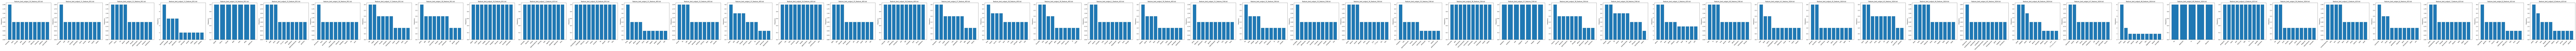


=== Cosine Similarity (TF-IDF) ===
             feature_text_output_10_feature_425.txt feature_text_output_11_feature_951.txt feature_text_output_12_feature_951.txt feature_text_output_13_feature_951.txt feature_text_output_14_feature_951.txt feature_text_output_15_feature_951.txt feature_text_output_16_feature_951.txt feature_text_output_17_feature_951.txt feature_text_output_18_feature_951.txt feature_text_output_19_feature_951.txt feature_text_output_1_feature_425.txt feature_text_output_20_feature_951.txt feature_text_output_21_feature_405.txt feature_text_output_22_feature_405.txt feature_text_output_23_feature_405.txt feature_text_output_24_feature_405.txt feature_text_output_25_feature_405.txt feature_text_output_26_feature_405.txt feature_text_output_27_feature_405.txt feature_text_output_28_feature_405.txt feature_text_output_29_feature_405.txt feature_text_output_2_feature_425.txt feature_text_output_30_feature_405.txt feature_text_output_31_feature_536.txt feature_text_outp

/usr/local/lib/python3.12/dist-packages/sklearn/feature_extraction/text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


In [30]:
import os
import string
from collections import Counter
import numpy as np
import matplotlib.pyplot as plt

# Try to use sklearn TF-IDF if available
try:
    from sklearn.feature_extraction.text import TfidfVectorizer
    from sklearn.metrics.pairwise import cosine_similarity as sk_cosine_similarity
    SKLEARN_AVAILABLE = True
except Exception:
    SKLEARN_AVAILABLE = False

# ------------------------
# Parameters (edit freely)
# ------------------------
INPUT_DIR = "feature_text_output"   # directory with text files
TOP_N = 10             # top N frequent words per file
TOP_K_JACCARD = 50     # top K words per file for Jaccard

# Editable blacklist of stopwords
STOPWORDS = {
    "and", "is", "the", "a", "an", "of", "to", "in", "on", "for", "with", "at", "by",
    "it", "this", "that", "as", "be", "are", "was", "were", "from", "or", "not"
}

# ------------------------
# Helpers
# ------------------------
def tokenize(text: str):
    """Lowercase, remove punctuation, split, filter stopwords."""
    trans_table = str.maketrans({ch: " " for ch in string.punctuation})
    tokens = text.lower().translate(trans_table).split()
    return [t for t in tokens if t not in STOPWORDS and not t.isnumeric() and len(t) > 1]

def read_files(input_dir: str):
    texts = {}
    for filename in sorted(os.listdir(input_dir)):
        if filename.lower().endswith(".txt"):
            path = os.path.join(input_dir, filename)
            with open(path, "r", encoding="utf-8") as f:
                texts[filename] = f.read()
    return texts

def counters_from_texts(texts: dict):
    tokens_by_file = {fn: tokenize(txt) for fn, txt in texts.items()}
    counters = {fn: Counter(toks) for fn, toks in tokens_by_file.items()}
    return tokens_by_file, counters

# ------------------------
# Similarity metrics
# ------------------------
def cosine_similarity_from_counts(counters: dict):
    filenames = list(counters.keys())
    vocab = sorted({w for c in counters.values() for w in c.keys()})
    idx = {w: i for i, w in enumerate(vocab)}
    M = np.zeros((len(filenames), len(vocab)), dtype=float)
    for r, fn in enumerate(filenames):
        for w, cnt in counters[fn].items():
            M[r, idx[w]] = cnt
    norms = np.linalg.norm(M, axis=1, keepdims=True)
    norms[norms == 0] = 1.0
    M_norm = M / norms
    sim = M_norm @ M_norm.T
    return filenames, sim

def cosine_similarity_tfidf(tokens_by_file: dict):
    filenames = list(tokens_by_file.keys())
    docs = [" ".join(tokens_by_file[fn]) for fn in filenames]
    vectorizer = TfidfVectorizer(tokenizer=lambda s: s.split(), preprocessor=lambda s: s)
    X = vectorizer.fit_transform(docs)
    sim = sk_cosine_similarity(X)
    return filenames, sim

def jaccard_similarity_topk(counters: dict, k: int):
    filenames = list(counters.keys())
    top_sets = []
    for fn in filenames:
        top_words = [w for w, _ in counters[fn].most_common(k)]
        top_sets.append(set(top_words))
    n = len(filenames)
    sim = np.zeros((n, n), dtype=float)
    for i in range(n):
        for j in range(n):
            if i == j:
                sim[i, j] = 1.0
            else:
                inter = len(top_sets[i].intersection(top_sets[j]))
                union = len(top_sets[i].union(top_sets[j]))
                sim[i, j] = inter / union if union > 0 else 0.0
    return filenames, sim

# ------------------------
# Printing utilities
# ------------------------
def print_similarity_matrix(labels, sim, title):
    print(f"\n=== {title} ===")
    header = " ".join([f"{lbl:>12}" for lbl in labels])
    print(f"{'':12} {header}")
    for lbl, row in zip(labels, sim):
        row_str = " ".join([f"{val:12.2f}" for val in row])
        print(f"{lbl:12} {row_str}")

# ------------------------
# Plotting frequencies
# ------------------------
def plot_word_frequencies(counters: dict, top_n: int = 10):
    filenames = list(counters.keys())
    num_files = len(filenames)
    if num_files == 0:
        print("No files to plot.")
        return
    fig, axes = plt.subplots(1, num_files, figsize=(6 * num_files, 6), squeeze=False)
    axes = axes[0]
    for ax, fn in zip(axes, filenames):
        common = counters[fn].most_common(top_n)
        words = [w for w, _ in common]
        counts = [c for _, c in common]
        ax.bar(range(len(words)), counts)
        ax.set_title(fn)
        ax.set_ylabel("Frequency")
        ax.set_xticks(range(len(words)))
        ax.set_xticklabels(words, rotation=45, ha="right")
    plt.tight_layout()
    plt.show()

# ------------------------
# Main
# ------------------------
def main():
    texts = read_files(INPUT_DIR)
    if not texts:
        print(f"No .txt files found in {INPUT_DIR}")
        return

    tokens_by_file, counters = counters_from_texts(texts)

    # 1) Plot top-N word frequencies
    plot_word_frequencies(counters, top_n=TOP_N)

    # 2) Cosine similarity
    if SKLEARN_AVAILABLE:
        labels, cos_sim = cosine_similarity_tfidf(tokens_by_file)
        print_similarity_matrix(labels, cos_sim, "Cosine Similarity (TF-IDF)")
    else:
        labels, cos_sim = cosine_similarity_from_counts(counters)
        print_similarity_matrix(labels, cos_sim, "Cosine Similarity (Counts)")

    # 3) Jaccard similarity
    labels_j, jac_sim = jaccard_similarity_topk(counters, k=TOP_K_JACCARD)
    print_similarity_matrix(labels_j, jac_sim, f"Jaccard Similarity (Top-{TOP_K_JACCARD} words)")

if __name__ == "__main__":
    main()
